In [1]:
%matplotlib inline
# Load islpy and islplot
from islpy import *
from islplot.plotter import *

以此为例：
``` c
for(int i=0; i<=6; i++) {
    for(int j=0; j<=6; j++)
        S[i,j] = 0.25*((S[i-1,j-1]+2*S[i,j-1]+S[i+1,j-1]));
}
```
可以得到如下迭代空间以及依赖关系

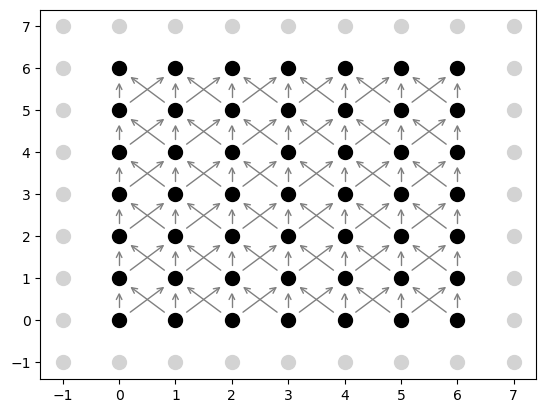

In [2]:
domain = Set("{[i,j]: 0<=i<=6 and 0<=j<=6}")
dependences = Map("{[i,j]-> [i-1,j+1]; [i,j]-> [i,j+1]; [i,j]-> [i+1,j+1]}")
plot_domain(domain, dependences)

我们通过循环分块期望提高数据局部性，数据局部性的提高可以Cache命中率 （yes?）

假设一个二维数组 a[2][2] 的空间排布顺序为 a[0][0], a[0][1], a[1][0], a[1][1], 即行优先存储

一种正确的循环分块方式如下所示：

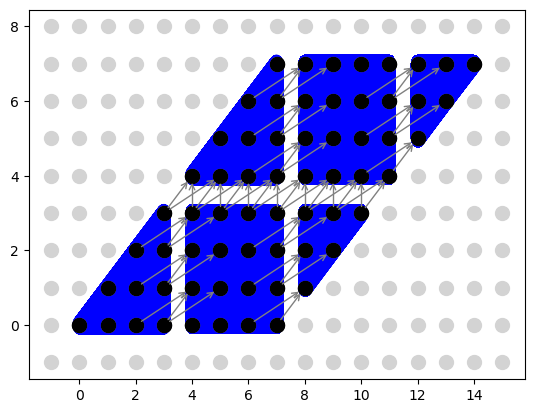

In [3]:
domain = Set("{[x,y]: 0<=x<8 and 0<=y<8}")
dependences = Map("{[i,j]-> [i-1,j+1]; [i,j]-> [i,j+1]; [i,j]-> [i+1,j+1]}")
space = Map("{[i,j] -> [i+j,j]}")
tiling = Map("{[i,j] -> [floor((i+j)/4),floor(j/4)]}")
plot_domain(domain, dependences, tiling, space, shrink=5)

那么在这种分块方式下，如[i+j,j]=[8,4]所在的块中，所需要访问的数据也就呈“L”形排布(仅考虑读cache)，换句话说就是存在某些需要访问的数据是跳跃分布的，那么这些跳跃分布的数据就更容易 Cache miss

为什么不采取以下这种排布方式呢？(分块大小仅作示意参考)

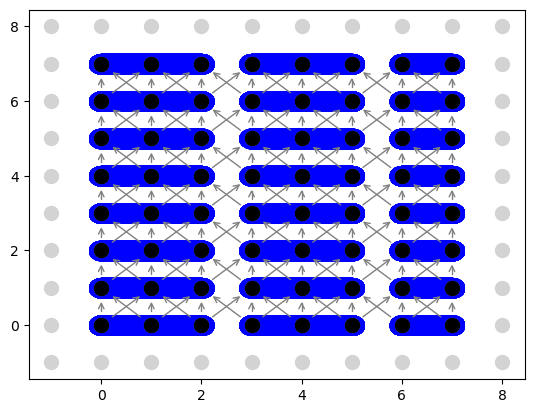

In [4]:

domain = Set("{[i,j]: 0<=i<8 and 0<=j<8}")
dependences = Map("{[i,j]-> [i-1,j+1]; [i,j]-> [i,j+1]; [i,j]-> [i+1,j+1]}")
tiling = Map("{[i,j] -> [floor(i/3),j]}")
plot_domain(domain, dependences, tiling)

按照这种方式进行分块，计算每个分块所需要访问的数据都是连续存储的，理论上来说应该更利于cache命中

但为什么第一种分块方式是正确的方式，而不考虑第二种？

## PPCG示例

``` c
#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#define M 128
#define N 256
int main() {
    int A[M][N];
    for (int i=0; i<N; i++) {
        A[0][i] = i;
    }
	clock_t start, end;
	start = clock();
#pragma scop
    for(int i=0; i<M-1; i++) {
        for(int j=0; j<N; j++) {
            A[i+1][j] = 0.125 * ((j>=1?6*A[i][j-1]:0)+ A[i][j] + (j<N-1?A[i][j+1]:0));
        }
    }
#pragma endscop

    for(int i=0; i<M-1; i++) {
        for(int j=0; j<N; j++) {
            printf("%d", A[i][j]);
            int mod = A[i][j] / 10;
            if(mod) printf(" ");
            else printf("  ");
        }
        printf("\n");
    }

	end = clock();
	
	double time_spent = (double)(end - start) / CLOCKS_PER_SEC;
	printf("time spent: %f\n", time_spent);
	return EXIT_SUCCESS;
}
```

### test_host.cu

``` cuda
{
// ...
      int *dev_A;
      for (int c0 = 0; c0 <= 126; c0 += 1)
        {
          dim3 k0_dimBlock(32);
          dim3 k0_dimGrid(8);
          kernel0 <<<k0_dimGrid, k0_dimBlock>>> (dev_A, c0);
          cudaCheckKernel();
        }

	return EXIT_SUCCESS;
// ...
}
```

### test_kernel.cu
``` cuda
#include "test_kernel.hu"
__global__ void kernel0(int *A, int c0)
{
    int b0 = blockIdx.x;
    int t0 = threadIdx.x;

    A[(c0 + 1) * 256 + (32 * b0 + t0)] = (0.125 * ((((b0 == 0 && t0 == 0 ? 0 : 1) ? (6 * A[c0 * 256 + (32 * b0 + t0 - 1)]) : 0) + A[c0 * 256 + (32 * b0 + t0)]) + ((b0 == 7 && t0 == 31 ? 0 : 1) ? A[c0 * 256 + (32 * b0 + t0 + 1)] : 0)));
}

```

由以上ppcg生成的代码来看，确实是按照第二种方式进行分块的。

# Ans
在ppcg中看似是使用了第二种方式进行分块，但实际上ppcg是考虑了程序的并行性，并未对语句进行分块。

关于数据局部性的理解没问题。